## 进行时间切分实验

In [1]:
# tensorflow GPU的设置
import tensorflow as tf 

# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

print(tf.__version__)

2.4.1


In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from collections import Counter

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# 加载数据 为平衡数据量，将2018年3月之前的数据和2017年的数据合并
def judge_1(time):
    time = time[:7].replace('-', '')
    if time <= '201803':
        return True
    else:
        return False

def judge_2(time):
    time = time[:7].replace('-', '')
    if time > '201803':
        return True
    else:
        return False

name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}
data_csv = pd.read_csv('../../csv/dataset_handled.csv')
data_2017 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2017']
data_2018 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2018']
data_2019 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2019']
    
data_2018_1 = data_2018[data_2018['first_seen'].apply(judge_1)]
data_2018_2 = data_2018[data_2018['first_seen'].apply(judge_2)]

data_train = data_2017.append(data_2018_１)
data_test_1 = data_2018_2
data_test_2 = data_2019

print("划分数据集后的数据统计:")
print(data_train.shape, data_test_1.shape, data_test_2.shape)
print(Counter(data_train.label))
print(Counter(data_test_1.label))
print(Counter(data_test_2.label))

data_test_1.to_csv("data_test_1.csv", index=0)
data_test_2.to_csv("data_test_2.csv", index=0)

# 对测试集进行下采样
data_train = data_train.sample(frac=1, random_state=1).reset_index(drop=True)
data_test_1 = data_test_1.sample(frac=0.73, random_state=1).reset_index(drop=True)
data_test_2 = data_test_2.sample(frac=0.54, random_state=1).reset_index(drop=True)

print("采样后的数据统计：")
print(data_train.shape, data_test_1.shape, data_test_2.shape)
print(Counter(data_train['label']), Counter(data_test_１['label']), Counter(data_test_2['label']), Counter(data_csv['label']))

划分数据集后的数据统计:
(6929, 9) (2668, 9) (3878, 9)
Counter({'worm': 1900, 'virus': 1865, 'trojan': 1783, 'backdoor': 1381})
Counter({'trojan': 817, 'virus': 735, 'worm': 559, 'backdoor': 557})
Counter({'trojan': 1000, 'virus': 1000, 'worm': 1000, 'backdoor': 878})
采样后的数据统计：
(6929, 9) (1948, 9) (2094, 9)
Counter({'worm': 1900, 'virus': 1865, 'trojan': 1783, 'backdoor': 1381}) Counter({'trojan': 589, 'virus': 541, 'worm': 415, 'backdoor': 403}) Counter({'trojan': 553, 'virus': 538, 'worm': 523, 'backdoor': 480}) Counter({'trojan': 3600, 'virus': 3600, 'worm': 3459, 'backdoor': 2816})


In [4]:
from utils import *
data_path_1, labels_1 = path_loader(data_train)
data_path_2, labels_2 = path_loader(data_test_1)
data_path_3, labels_3 = path_loader(data_test_2)

In [5]:
# 加载数据并进行训练
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Sequential, metrics
from tensorflow.keras import Input, Model, regularizers
from malconv import get_malconv


batch_size = 128
db_train = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_train = db_train.batch(batch_size).repeat(32)

db_val = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = db_val.batch(batch_size).repeat(32)

model = get_malconv()
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(db_train,
                    epochs=30,
                    steps_per_epoch=46,
                    validation_data=db_val,
                    validation_steps=30)

Epoch 1/30
46/46 [==============================] - 492s 11s/step - loss: 1.8604 - categorical_accuracy: 0.6747 - val_loss: 0.9010 - val_categorical_accuracy: 0.9091
Epoch 2/30
46/46 [==============================] - 388s 8s/step - loss: 0.7715 - categorical_accuracy: 0.9302 - val_loss: 0.4798 - val_categorical_accuracy: 0.9755
Epoch 3/30
46/46 [==============================] - 375s 8s/step - loss: 0.4487 - categorical_accuracy: 0.9731 - val_loss: 0.3183 - val_categorical_accuracy: 0.9901
Epoch 4/30
46/46 [==============================] - 376s 8s/step - loss: 0.3034 - categorical_accuracy: 0.9861 - val_loss: 0.2341 - val_categorical_accuracy: 0.9951
Epoch 5/30
46/46 [==============================] - 375s 8s/step - loss: 0.2252 - categorical_accuracy: 0.9951 - val_loss: 0.1799 - val_categorical_accuracy: 0.9979
Epoch 6/30
46/46 [==============================] - 377s 8s/step - loss: 0.1761 - categorical_accuracy: 0.9978 - val_loss: 0.1519 - val_categorical_accuracy: 0.9979
Epoch 7/3

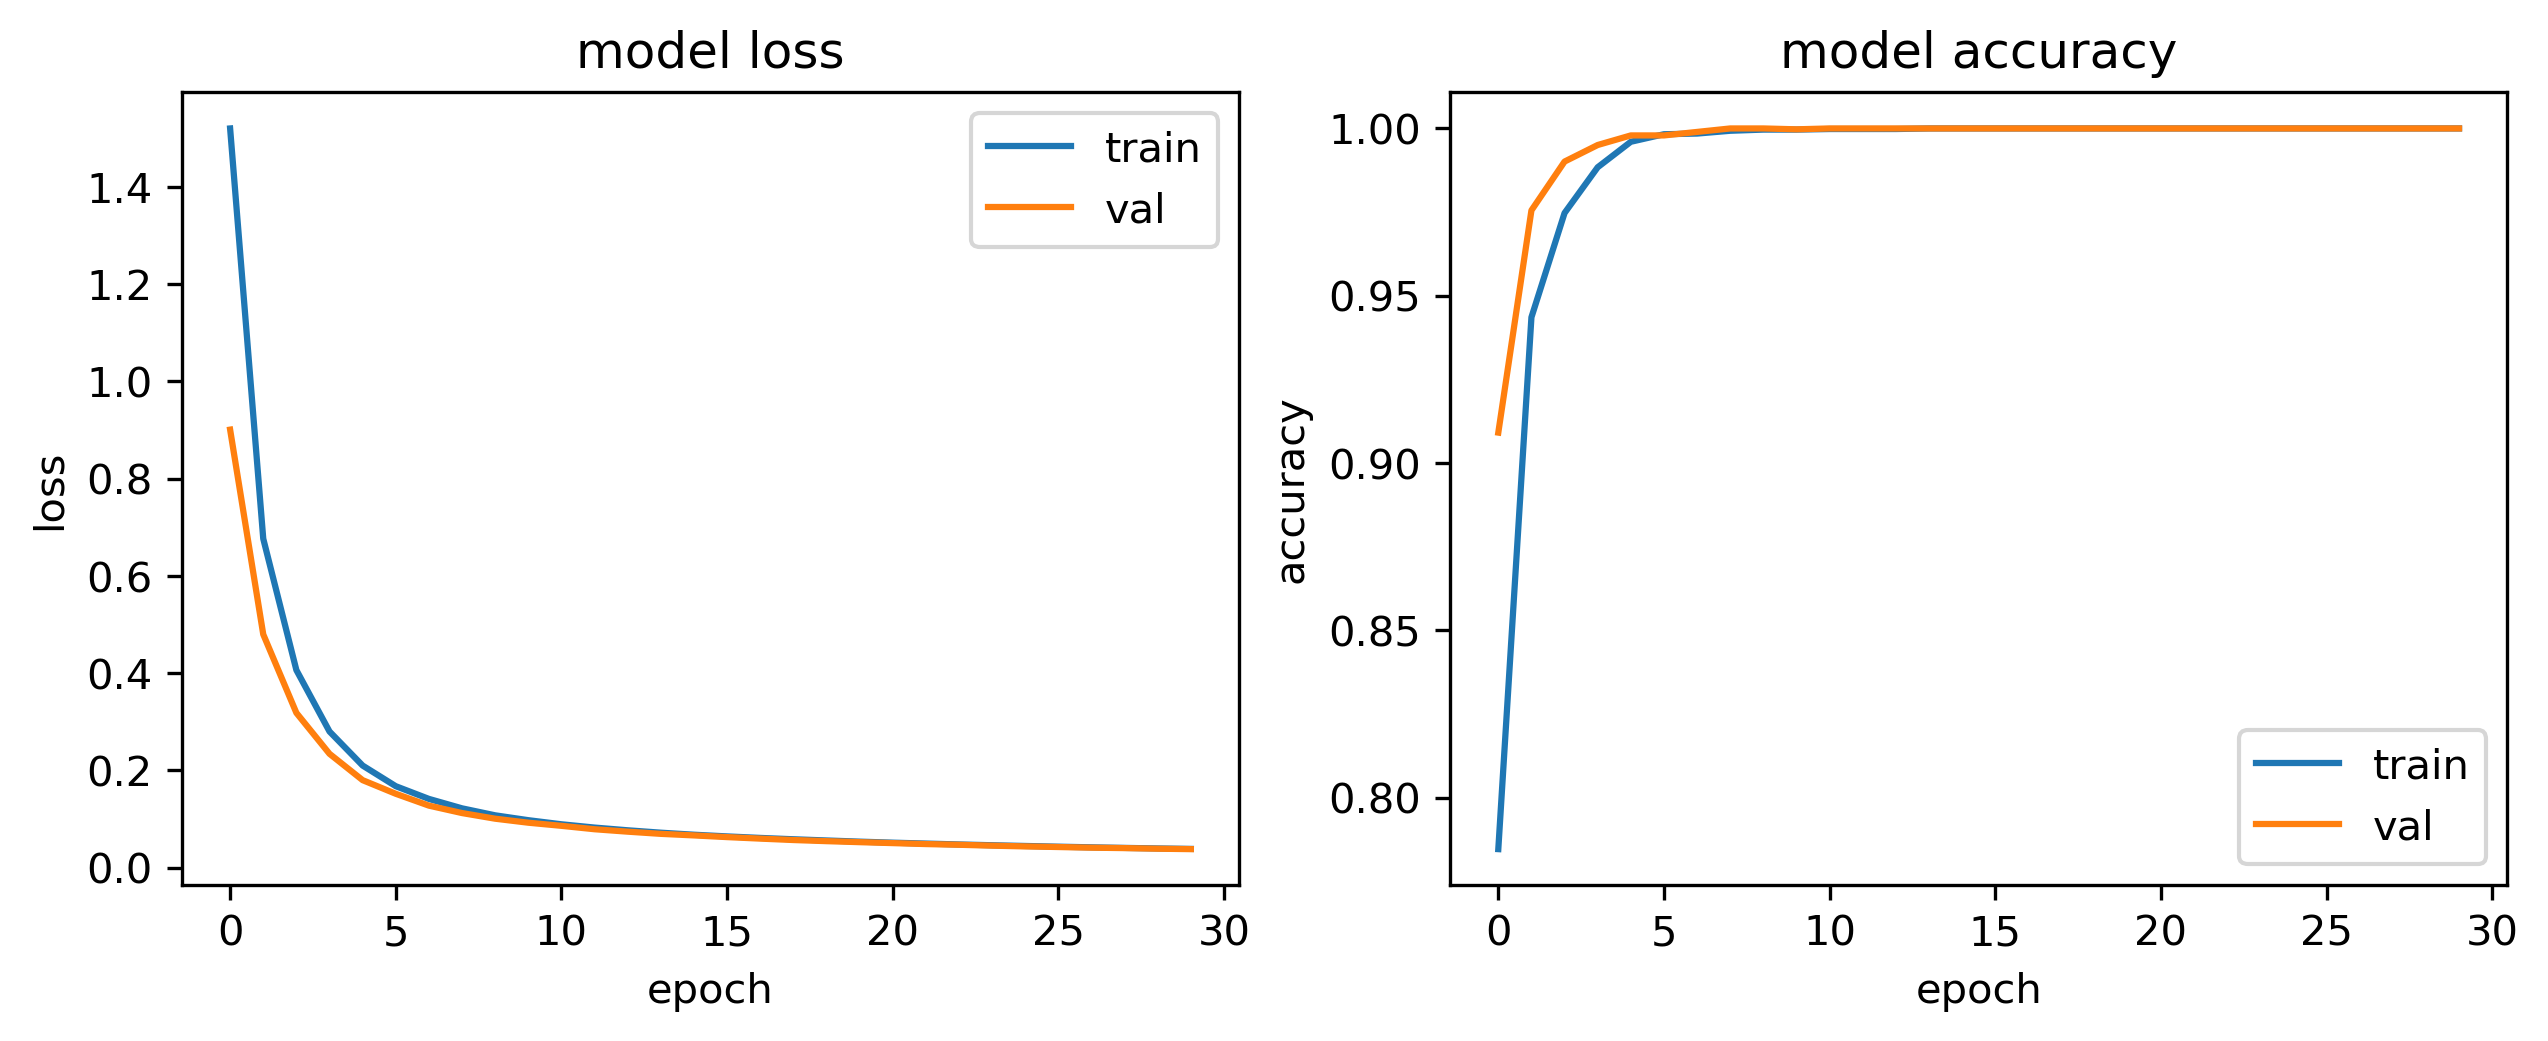

In [6]:
 # 绘制loss和acc曲线
def PlotLoss(model_name, history):
    
    p1 = plt.figure(figsize=(10, 3.5),dpi=300)
    ax1 = p1.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="upper right")

    ax2 = p1.add_subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="lower right")
    plt.savefig("./figures/" + model_name + '.png')

PlotLoss('malconv_split', history)

In [11]:
# 进行模型保存
model.save('../model/malconv_split.h5')

In [8]:
# 测试数据
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('../model/malconv_split.h5')
# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_2), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_2[idx:idx+batch_size], labels_2[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 48/48 [00:00<00:00, 165.96it/s]
              precision    recall  f1-score   support

    backdoor     0.8256    0.9966    0.9031       589
        worm     0.9782    0.9963    0.9872       541
       virus     0.9942    0.8265    0.9026       415
      trojan     0.9531    0.8065    0.8737       403

    accuracy                         0.9209      1948
   macro avg     0.9378    0.9065    0.9166      1948
weighted avg     0.9303    0.9209    0.9203      1948



In [9]:
# 2019年测试集
# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_3), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_3[idx:idx+batch_size], labels_3[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)

target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 94/94 [00:02<00:00, 43.76it/s]
              precision    recall  f1-score   support

    backdoor     0.8048    0.9620    0.8764       553
        worm     0.9718    0.9610    0.9664       538
       virus     0.9451    0.7897    0.8604       523
      trojan     0.8987    0.8688    0.8835       480

    accuracy                         0.8973      2094
   macro avg     0.9051    0.8954    0.8967      2094
weighted avg     0.9043    0.8973    0.8972      2094



In [10]:
# 训练数据
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('../model/malconv_split.h5')

# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_1), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_1[idx:idx+batch_size], labels_1[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)

# codes_train, labels_train = train_data_loader(data_path_１, labels_１, 'train')
# y_pred = model.predict(codes_train)
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(labels_train, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=6))

100%|██████████| 29/29 [00:01<00:00, 25.28it/s]
              precision    recall  f1-score   support

    backdoor   1.000000  1.000000  1.000000      1783
        worm   1.000000  1.000000  1.000000      1865
       virus   1.000000  1.000000  1.000000      1900
      trojan   1.000000  1.000000  1.000000      1381

    accuracy                       1.000000      6929
   macro avg   1.000000  1.000000  1.000000      6929
weighted avg   1.000000  1.000000  1.000000      6929

